## Active Learning


In [147]:
import os
import time
import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10

from sklearn.utils import check_random_state
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

%load_ext tensorboard
early_stop = EarlyStopping(monitor='val_loss', patience=2)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
trainset_size = 50000
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck']

def get_dataset():
  (X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()
  # summarize loaded dataset
  print('Train: X=%s, y=%s' % (X_train_full.shape, y_train_full.shape))
  print('Test: X=%s, y=%s' % (X_test.shape, y_test.shape))
  print(type(X_train_full[0]))
  print(type(y_train_full[0][0]))
  return (X_train_full, y_train_full, X_test, y_test)

In [0]:
class Normalize(object):
    
    def normalize(self, X, y):
        X = X.astype('float32')/255.
        y = y.astype('int32')
        return (X, y) 
    
    def inverse(self, X, y):
        X = X.astype('float32')*255.
        y = y.astype('int32')
        return (X, y) 

In [0]:
def get_k_random_samples(initial_labeled_samples, X_train_full,
                         y_train_full):
    random_state = check_random_state(0)
    permutation = np.random.choice(trainset_size,
                                   initial_labeled_samples,
                                   replace=False)
    print ()
    print ('initial random chosen samples', permutation.shape)
    #, permutation)
    X_train = X_train_full[permutation]
    y_train = y_train_full[permutation]
    #X_train = X_train.reshape((X_train.shape[0], -1))
    #print('X train shape :',X_train.shape)
    y_train_bin = y_train.reshape(1000,)
    bin_count = np.bincount(y_train_bin.astype('int64'))
    unique = np.unique(y_train)
    print ( 'initial train set:', X_train.shape, y_train.shape,
        'labels count:', bin_count, unique,
        )
    return (permutation, X_train, y_train)

In [0]:
def plot_fun(X, y):
  #X_train, X_test = X_train.astype('int32')*255. , X_test.astype('int8')*255.

  # Define the labels of the dataset
  labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
            'dog', 'frog', 'horse', 'ship', 'truck']

  # Let's view more images in a grid format
  # Define the dimensions of the plot grid 
  W_grid = 10
  L_grid = 10

  # fig, axes = plt.subplots(L_grid, W_grid)
  # subplot return the figure object and axes object
  # we can use the axes object to plot specific figures at various locations

  fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

  axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

  n_train = len(X) # get the length of the train dataset

  # Select a random number from 0 to n_train
  for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

      # Select a random number
      index = np.random.randint(0, n_train)
      # read and display an image with the selected index    
      axes[i].imshow(X[index,1:])
      label_index = int(y[index])
      axes[i].set_title(labels[label_index], fontsize = 8)
      axes[i].axis('off')

  plt.subplots_adjust(hspace=0.4)

In [0]:
class BaseSelectionFunction(object):

    def __init__(self):
        pass

    def select(self):
        pass


class RandomSelection(BaseSelectionFunction):

    @staticmethod
    def select(probas_val, initial_labeled_samples):
        random_state = check_random_state(0)
        selection = np.random.choice(probas_val.shape[0], initial_labeled_samples, replace=False)

#     print('uniques chosen:',np.unique(selection).shape[0],'<= should be equal to:',initial_labeled_samples)

        return selection

# class QBC(BaseSelectionFunction):

#     @staticmethod
#     def select()


#       return selection

In [0]:
# class Resnet50Model:

#     def __init__(self):
#       pass

#     def fit_predict(self):
#         pass

#     model_type = 'Resnet50'
#     def train_resnet50(self, X_train, y_train, X_test, y_test):

#         self.X_train, self.X_val, self.y_train, self.y_val = train_test_split( self.X_train, self.y_train, test_size=0.33, random_state=42)
#         print('X_train :', self.X_train.shape)
#         print('y train :', self.y_train.shape)
#         print('X val :', self.X_val.shape)
#         print('y val:', self.y_val.shape)

#         self.model = Sequential()

#         # Convolutional Layer
#         self.model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
#         # Pooling layer
#         self.model.add(MaxPool2D(pool_size=(2, 2)))
#         # Dropout layers
#         self.model.add(Dropout(0.25))

#         self.model.add(Conv2D(filters=64, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
#         self.model.add(MaxPool2D(pool_size=(2, 2)))
#         self.model.add(Dropout(0.25))

#         self.model.add(Conv2D(filters=128, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
#         self.model.add(MaxPool2D(pool_size=(2, 2)))
#         self.model.add(Dropout(0.25))

#         self.model.add(Flatten())
#         # model.add(Dropout(0.2))
#         self.model.add(Dense(512, activation='relu'))
#         self.model.add(Dropout(0.25))
#         self.model.add(Dense(10, activation='softmax'))

#         self.model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#         early_stop = EarlyStopping(monitor='val_loss', patience=2)

#         r = self.model.fit(X_train, y_train,  epochs=50, validation_data=(X_val, y_val))

#         plt.figure(figsize=(12, 8))

#         plt.subplot(2, 2, 1)
#         plt.plot(r.history['loss'], label='Loss')
#         plt.plot(r.history['val_loss'], label='val_Loss')
#         plt.legend()
#         plt.title('Loss evolution')

#         plt.subplot(2, 2, 2)
#         plt.plot(r.history['accuracy'], label='accuracy')
#         plt.plot(r.history['val_accuracy'], label='val_accuracy')
#         plt.legend()
#         plt.title('Accuracy evolution')

#         # Evaluate the model on the test data using `evaluate`
#         print('\n# Evaluate on test data')
#         results = model.evaluate(X_test, y_test, batch_size=128)
#         print('test loss, test acc:', results)
        
#         self.test_y_predicted = self.model.predict(X_test)
#         self.val_y_predicted  = self.model.predict(X_val)

#         cm = confusion_matrix(y_test, self.test_y_predicted)
#         disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
#         fig, ax = plt.subplots(figsize=(10, 10))
#         disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
#         plt.show()

#         # print('***************')
#         # print(self.val_y_predicted)
#         # print('***************')
#         # #self.test_y_predicted = self.classifier.predict(X_test)
#         # #self.val_y_predicted = self.classifier.predict(X_val)
#         # self.val_y_predicted2 = self.model.predict_proba(X_val)
#         # print('***************')
#         # print(self.val_y_predicted2)
#         # print('***************')
#         return (X_train, X_test)

In [0]:
    def train_resnet50( X_train_org, y_train_org,X_seedset, X_test, y_test):

        X_train, X_val, y_train, y_val = train_test_split( X_train_org, y_train_org, test_size=0.3, random_state=42)
        print('X_train :', X_train.shape)
        print('y train :', y_train.shape)
        print('X val :', X_val.shape)
        print('y val:', y_val.shape)

        model = Sequential()

        # Convolutional Layer
        model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
        # Pooling layer
        model.add(MaxPool2D(pool_size=(2, 2)))
        # Dropout layers
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=64, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(filters=128, kernel_size=(4, 4), input_shape=(32, 32, 3), activation='relu', padding='same'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        # model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(10, activation='softmax'))

        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        early_stop = EarlyStopping(monitor='val_loss', patience=2)

        r = model.fit(X_train, y_train,  epochs=200, validation_data=(X_val, y_val))

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(r.history['loss'], label='Loss')
        plt.plot(r.history['val_loss'], label='val_Loss')
        plt.legend()
        plt.title('Loss evolution')

        plt.subplot(2, 2, 2)
        plt.plot(r.history['accuracy'], label='accuracy')
        plt.plot(r.history['val_accuracy'], label='val_accuracy')
        plt.legend()
        plt.title('Accuracy evolution')

        # Evaluate the model on the test data using `evaluate`
        print('\n# Evaluate on test data')
        results = model.evaluate(X_test, y_test, batch_size=128)
        print('test loss, test acc:', results)
        
        test_y_predicted = model.predict(X_test)
        test_y_predicted = np.argmax(test_y_predicted, axis=1)
        #test_y_predicted = (model.predict(X_test) > 0.5).astype("int32")
        val_y_predicted  = model.predict(X_val)
        val_y_predicted = np.argmax(val_y_predicted, axis=1)
        #val_y_predicted = (model.predict(X_val) > 0.5).astype("int32")
        # print(y_val.shape)
        # print(val_y_predicted.shape)
        # print(y_val)
        # print(val_y_predicted)
        cm = confusion_matrix(y_test, test_y_predicted)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        fig, ax = plt.subplots(figsize=(10, 10))
        disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')
        plt.show()

        probas_val = model.predict(X_seedset)
        print ('probabilities:', probas_val.shape, '\n', np.argmax(probas_val, axis=1))
        #print('----------------')
        #print(probas_val)
        #print('-----------------')
        record.loc[iterations] = [X_train_org.shape[0], X_seedset.shape[0], r.history['accuracy'][-1], r.history['loss'][-1],r.history['val_accuracy'][-1],r.history['val_loss'][1], results[1], results[0]]

        #uncertain_samples = self.sample_selection_function.select(probas_val, self.initial_labeled_samples)
        #print('Uncertain_samples :', uncertain_samples)
        return probas_val

In [0]:
#record training process
record = pd.DataFrame(columns=('TrainDS','Seedset', 'Train_Accuracy', 'Train_Loss', 'Val_Accuracy', 'Val_Loss', 'Test_Accuracy', 'Test_Loss' ))

In [156]:
X_train_full, y_train_full, X_test, y_test = get_dataset()

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)
<class 'numpy.ndarray'>
<class 'numpy.uint8'>


In [157]:
print(X_train_full.shape)
print(y_train_full.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [158]:
permutation, X_train, y_train = get_k_random_samples(1000, X_train_full, y_train_full)
print(X_train_full.shape)
print(y_train_full.shape)
print(X_train.shape)
print(y_train.shape)
print(permutation.shape)


initial random chosen samples (1000,)
initial train set: (1000, 32, 32, 3) (1000, 1) unique(labels count): [103  98  93 108  99  97  88 107  93 114] [0 1 2 3 4 5 6 7 8 9]
(50000, 32, 32, 3)
(50000, 1)
(1000, 32, 32, 3)
(1000, 1)
(1000,)


In [159]:
X_seedset = np.array([])
y_seedset = np.array([])
X_seedset = np.copy(X_train_full)
X_seedset = np.delete(X_seedset, permutation, axis=0)
y_seedset = np.copy(y_train_full)
y_seedset = np.delete(y_seedset, permutation, axis=0)
print ('seed set:', X_seedset.shape, y_seedset.shape, permutation.shape)
print ()

seed set: (49000, 32, 32, 3) (49000, 1) (1000,)



X_train : (700, 32, 32, 3)
y train : (700, 1)
X val : (300, 32, 32, 3)
y val: (300, 1)
Epoch 1/200
22/22 [==============================] - 0s 21ms/step - loss: 2.3203 - accuracy: 0.0943 - val_loss: 2.2985 - val_accuracy: 0.0567
Epoch 2/200
22/22 [==============================] - 0s 15ms/step - loss: 2.2205 - accuracy: 0.1700 - val_loss: 2.1840 - val_accuracy: 0.2233
Epoch 3/200
22/22 [==============================] - 0s 15ms/step - loss: 2.1230 - accuracy: 0.2014 - val_loss: 2.0460 - val_accuracy: 0.2667
Epoch 4/200
22/22 [==============================] - 0s 14ms/step - loss: 2.0092 - accuracy: 0.2700 - val_loss: 1.9782 - val_accuracy: 0.2933
Epoch 5/200
22/22 [==============================] - 0s 14ms/step - loss: 1.8603 - accuracy: 0.3043 - val_loss: 1.8383 - val_accuracy: 0.3200
Epoch 6/200
22/22 [==============================] - 0s 14ms/step - loss: 1.8007 - accuracy: 0.3200 - val_loss: 1.9149 - val_accuracy: 0.3033
Epoch 7/200
22/22 [==============================] - 0s 14ms/

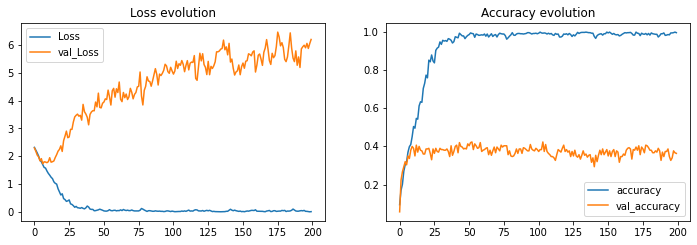

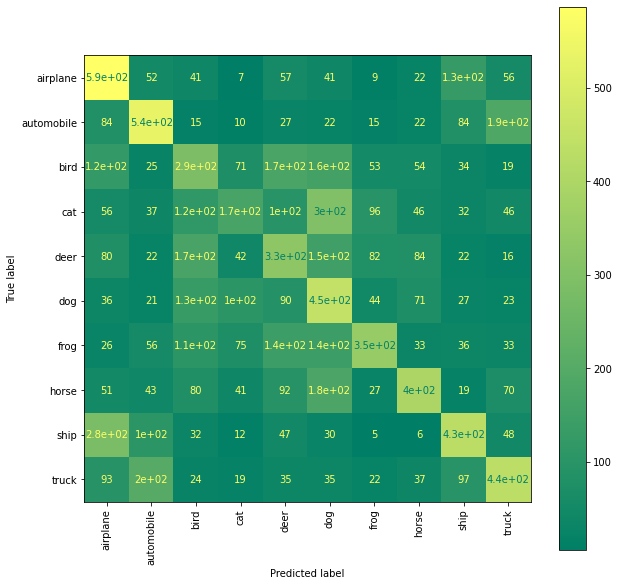

probabilities: (49000, 10) 
 [4 8 9 ... 8 1 7]


In [160]:
normalizer = Normalize()
X_train, y_train = normalizer.normalize( X_train, y_train)
X_test, y_test = normalizer.normalize(X_test, y_test)
X_seedset, y_seedset = normalizer.normalize(X_seedset, y_seedset)

#resnet50_model = Resnet50Model
iterations = 0
probas_val = train_resnet50(X_train, y_train, X_seedset,X_test, y_test)

In [161]:
uncertain_samples = RandomSelection.select(probas_val, 1000)
print('Uncertain_samples :', uncertain_samples)

Uncertain_samples : [38574  6106 33053 39388 31302 30749   720 23893  9905 32936 18707 23566
 43612 40761  3915 12438 42408 17854 38248 28208 32784 22536 16400  2464
 26264 48442 32965    54 30911 47352 44932 45995 12202 31252 18215 16071
 44060 32384 37414 28627 10620 20129 18494  5875 33918  4459 31607 39721
 32182  6268 10270 39667 42702 11387  2957 25979 20884 10895 24887 31835
 23145 19990  7647 14303   639 31016 25245 33454 10611 33397 24185 17480
  3355 29326 16881 42752 24580 47663 44242 27505 13902 39621  9579 38308
 28481 23028 37342 46408 39646 25135 13432 23812 12434 26497 20753 47449
 41889 23756  6376 16322 27340 20899  6074 41963 27132 28987   344 41464
 19325 43186 48696 29155 36978 27050 41118 19441  4891  3193 35318 24960
  7214 37595 28476  9272 23155  7189 24831  1850   795 40338 44221 17892
 21618 40791 27561 36817 24902 42353 12889  9043 24268 32435 42239 15260
 29686 41095 45358 43889 47283 40521 11710 27944 38411 10152  1028  4125
 33699 30966   871  1778 43757 

In [162]:
# normalization needs to be inversed and recalculated based on the new train and test set.
 
X_train, y_train = normalizer.inverse(X_train, y_train)
X_test, y_test = normalizer.inverse(X_test, y_test)
X_seedset, y_seedset = normalizer.inverse(X_seedset, y_seedset)   

# get the uncertain samples from the validation set

print ('trainset before', X_train.shape, y_train.shape)
X_train = np.concatenate((X_train, X_seedset[uncertain_samples]))
y_train = np.concatenate((y_train, y_seedset[uncertain_samples]))
print ('trainset after', X_train.shape, y_train.shape)
#self.samplecount.append(X_train.shape[0])
y_train.shape
y_train_bin = y_train.reshape((y_train.shape[0],))
bin_count = np.bincount(y_train_bin.astype('int64'))
unique = np.unique(y_train_bin.astype('int64'))
print ( 'updated train set:',
                X_train.shape,
                y_train.shape,
                'unique(labels):',
                bin_count,
                unique,
      )

X_seedset = np.delete(X_seedset, uncertain_samples, axis=0)
y_seedset = np.delete(y_seedset, uncertain_samples, axis=0)
print ('Seed set:', X_seedset.shape, y_seedset.shape)

trainset before (1000, 32, 32, 3) (1000, 1)
trainset after (2000, 32, 32, 3) (2000, 1)
updated train set: (2000, 32, 32, 3) (2000, 1) unique(labels): [190 199 223 197 207 198 188 193 193 212] [0 1 2 3 4 5 6 7 8 9]
Seed set: (48000, 32, 32, 3) (48000, 1)


In [0]:
# normalizer = Normalize()
# X_train, y_train = normalizer.normalize( X_train, y_train)
# X_test, y_test = normalizer.normalize(X_test, y_test)
# X_seedset, y_seedset = normalizer.normalize(X_seedset, y_seedset)

# #resnet50_model = Resnet50Model
# (X_train,y_train, X_test, y_test,probas_val) = train_resnet50(X_train, y_train, X_seedset,X_test, y_test)

X_train : (1400, 32, 32, 3)
y train : (1400, 1)
X val : (600, 32, 32, 3)
y val: (600, 1)
Epoch 1/200
44/44 [==============================] - 1s 15ms/step - loss: 2.2516 - accuracy: 0.1400 - val_loss: 2.1326 - val_accuracy: 0.2083
Epoch 2/200
44/44 [==============================] - 0s 11ms/step - loss: 2.0796 - accuracy: 0.2279 - val_loss: 2.0275 - val_accuracy: 0.2167
Epoch 3/200
44/44 [==============================] - 0s 11ms/step - loss: 1.9634 - accuracy: 0.2700 - val_loss: 1.8937 - val_accuracy: 0.3150
Epoch 4/200
44/44 [==============================] - 0s 11ms/step - loss: 1.8311 - accuracy: 0.3086 - val_loss: 1.9017 - val_accuracy: 0.3250
Epoch 5/200
44/44 [==============================] - 1s 11ms/step - loss: 1.7661 - accuracy: 0.3386 - val_loss: 1.7823 - val_accuracy: 0.3100
Epoch 6/200
44/44 [==============================] - 0s 11ms/step - loss: 1.6222 - accuracy: 0.4043 - val_loss: 1.7093 - val_accuracy: 0.3717
Epoch 7/200
44/44 [==============================] - 0s 11m

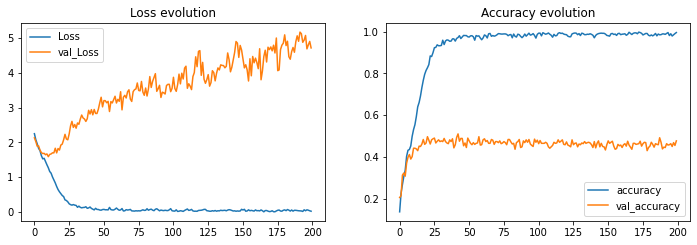

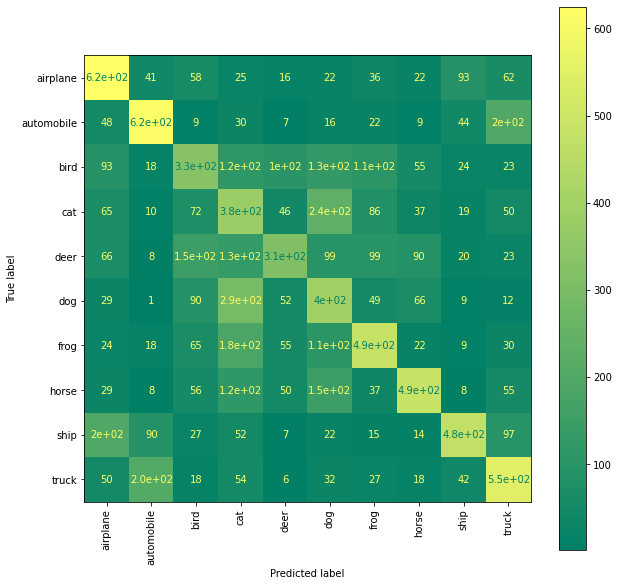

probabilities: (48000, 10) 
 [6 9 4 ... 1 1 1]
Uncertain_samples shape : (1000,)
trainset before (2000, 32, 32, 3) (2000, 1)
trainset after (3000, 32, 32, 3) (3000, 1)
updated train set: (3000, 32, 32, 3) (3000, 1) unique(labels): [293 311 301 294 324 317 285 280 279 316] [0 1 2 3 4 5 6 7 8 9]
Seed set: (47000, 32, 32, 3) (47000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (2100, 32, 32, 3)
y train : (2100, 1)
X val : (900, 32, 32, 3)
y val: (900, 1)
Epoch 1/200
66/66 [==============================] - 1s 13ms/step - loss: 2.2630 - accuracy: 0.1438 - val_loss: 2.2110 - val_accuracy: 0.2256
Epoch 2/200
66/66 [==============================] - 1s 11ms/step - loss: 1.9988 - accuracy: 0.2529 - val_loss: 1.8817 - val_accuracy: 0.3089
Epoch 3/200
66/66 [==============================] - 1s 11ms/step - loss: 1.8069 - accuracy: 0.3314 - val_loss: 1.7116 - val_accuracy: 0.3600
Epoch 4/200
66/66 [==============================] - 1s 11ms/step - loss: 1.6896 - accuracy

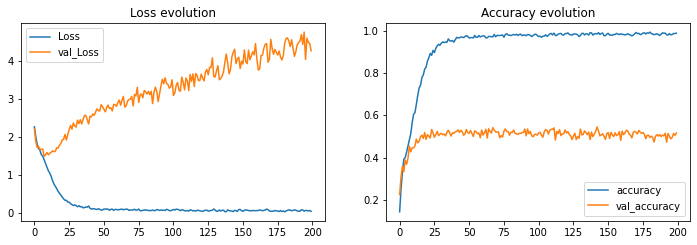

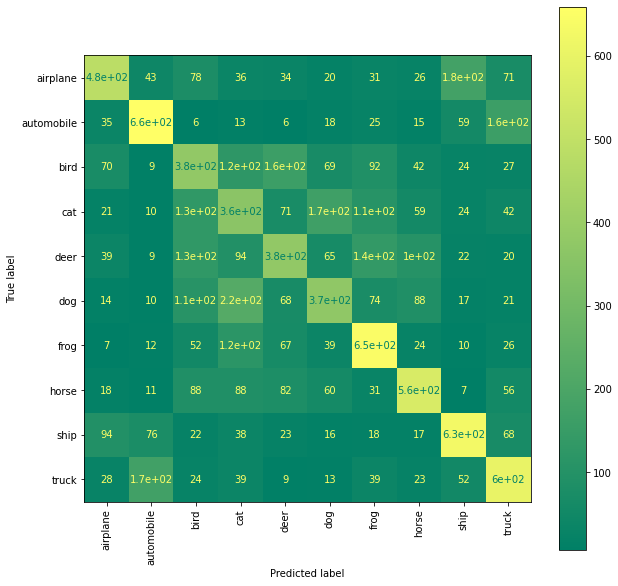

probabilities: (47000, 10) 
 [6 9 6 ... 9 1 7]
Uncertain_samples shape : (1000,)
trainset before (3000, 32, 32, 3) (3000, 1)
trainset after (4000, 32, 32, 3) (4000, 1)
updated train set: (4000, 32, 32, 3) (4000, 1) unique(labels): [383 408 392 404 431 430 387 376 389 400] [0 1 2 3 4 5 6 7 8 9]
Seed set: (46000, 32, 32, 3) (46000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (2800, 32, 32, 3)
y train : (2800, 1)
X val : (1200, 32, 32, 3)
y val: (1200, 1)
Epoch 1/200
88/88 [==============================] - 1s 12ms/step - loss: 2.1989 - accuracy: 0.1775 - val_loss: 2.0606 - val_accuracy: 0.2508
Epoch 2/200
88/88 [==============================] - 1s 11ms/step - loss: 1.9403 - accuracy: 0.2654 - val_loss: 1.8509 - val_accuracy: 0.3058
Epoch 3/200
88/88 [==============================] - 1s 11ms/step - loss: 1.7488 - accuracy: 0.3457 - val_loss: 1.7353 - val_accuracy: 0.3592
Epoch 4/200
88/88 [==============================] - 1s 11ms/step - loss: 1.6407 - accura

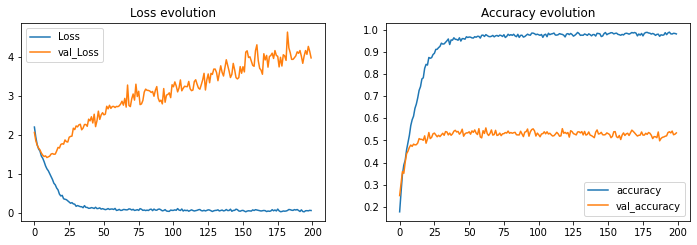

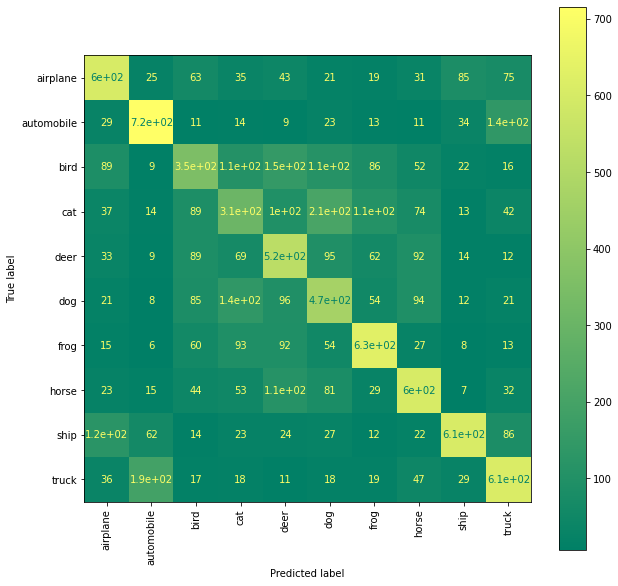

probabilities: (46000, 10) 
 [7 9 4 ... 1 1 7]
Uncertain_samples shape : (1000,)
trainset before (4000, 32, 32, 3) (4000, 1)
trainset after (5000, 32, 32, 3) (5000, 1)
updated train set: (5000, 32, 32, 3) (5000, 1) unique(labels): [487 520 489 507 554 520 466 467 491 499] [0 1 2 3 4 5 6 7 8 9]
Seed set: (45000, 32, 32, 3) (45000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (3500, 32, 32, 3)
y train : (3500, 1)
X val : (1500, 32, 32, 3)
y val: (1500, 1)
Epoch 1/200
110/110 [==============================] - 1s 12ms/step - loss: 2.1594 - accuracy: 0.1877 - val_loss: 1.9811 - val_accuracy: 0.2527
Epoch 2/200
110/110 [==============================] - 1s 11ms/step - loss: 1.8894 - accuracy: 0.2886 - val_loss: 1.7792 - val_accuracy: 0.3420
Epoch 3/200
110/110 [==============================] - 1s 11ms/step - loss: 1.7428 - accuracy: 0.3526 - val_loss: 1.7299 - val_accuracy: 0.3920
Epoch 4/200
110/110 [==============================] - 1s 11ms/step - loss: 1.6227 

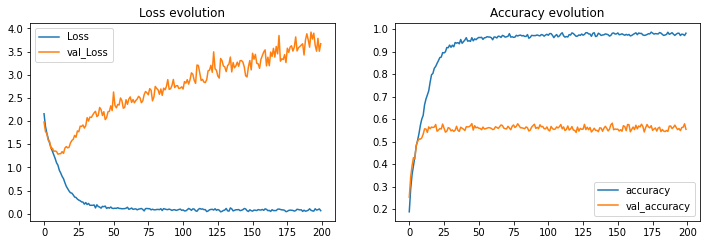

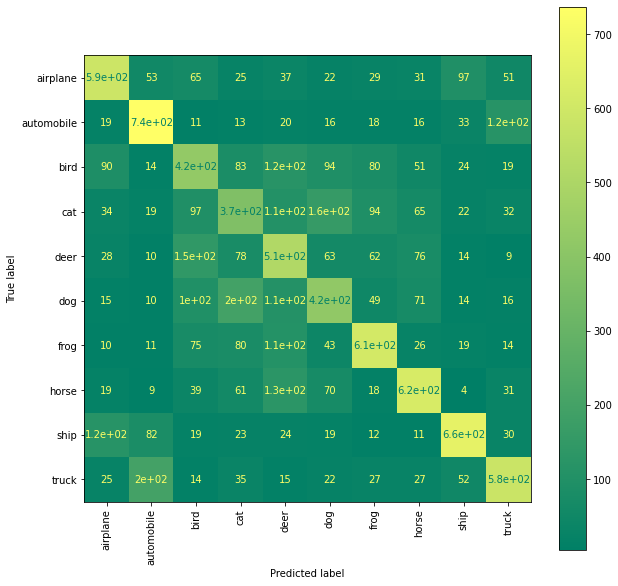

probabilities: (45000, 10) 
 [7 9 4 ... 2 1 9]
Uncertain_samples shape : (1000,)
trainset before (5000, 32, 32, 3) (5000, 1)
trainset after (6000, 32, 32, 3) (6000, 1)
updated train set: (6000, 32, 32, 3) (6000, 1) unique(labels): [575 628 587 606 653 621 582 565 583 600] [0 1 2 3 4 5 6 7 8 9]
Seed set: (44000, 32, 32, 3) (44000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (4200, 32, 32, 3)
y train : (4200, 1)
X val : (1800, 32, 32, 3)
y val: (1800, 1)
Epoch 1/200
132/132 [==============================] - 2s 12ms/step - loss: 2.1310 - accuracy: 0.1952 - val_loss: 2.0293 - val_accuracy: 0.2594
Epoch 2/200
132/132 [==============================] - 1s 11ms/step - loss: 1.8731 - accuracy: 0.3033 - val_loss: 1.7577 - val_accuracy: 0.3600
Epoch 3/200
132/132 [==============================] - 1s 11ms/step - loss: 1.7126 - accuracy: 0.3619 - val_loss: 1.6891 - val_accuracy: 0.4011
Epoch 4/200
132/132 [==============================] - 1s 11ms/step - loss: 1.5865 

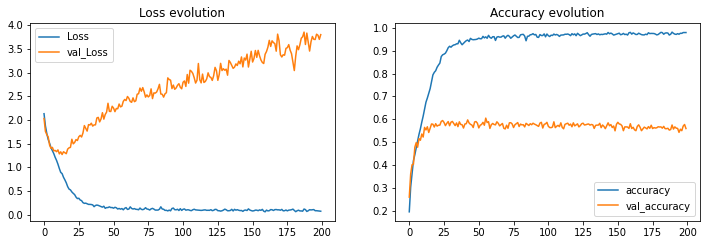

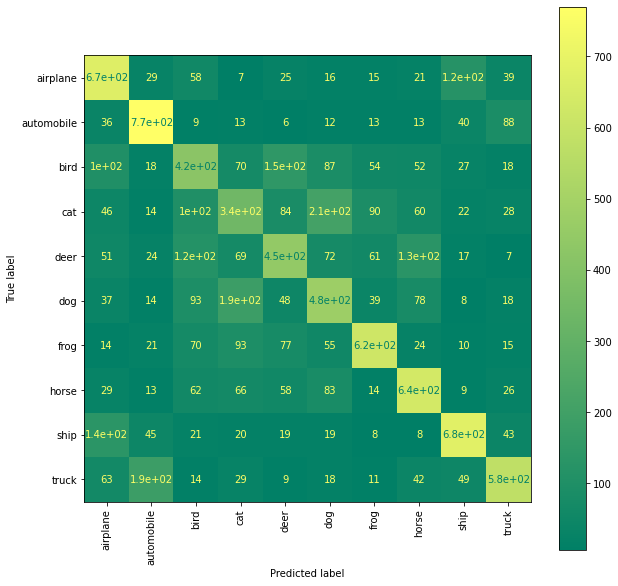

probabilities: (44000, 10) 
 [6 9 4 ... 6 1 8]
Uncertain_samples shape : (1000,)
trainset before (6000, 32, 32, 3) (6000, 1)
trainset after (7000, 32, 32, 3) (7000, 1)
updated train set: (7000, 32, 32, 3) (7000, 1) unique(labels): [671 732 698 707 765 720 670 673 673 691] [0 1 2 3 4 5 6 7 8 9]
Seed set: (43000, 32, 32, 3) (43000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (4900, 32, 32, 3)
y train : (4900, 1)
X val : (2100, 32, 32, 3)
y val: (2100, 1)
Epoch 1/200
154/154 [==============================] - 2s 12ms/step - loss: 2.1009 - accuracy: 0.2078 - val_loss: 1.8820 - val_accuracy: 0.2919
Epoch 2/200
154/154 [==============================] - 2s 11ms/step - loss: 1.8024 - accuracy: 0.3227 - val_loss: 1.6979 - val_accuracy: 0.3819
Epoch 3/200
154/154 [==============================] - 2s 11ms/step - loss: 1.6435 - accuracy: 0.3929 - val_loss: 1.6381 - val_accuracy: 0.4076
Epoch 4/200
154/154 [==============================] - 2s 11ms/step - loss: 1.5298 

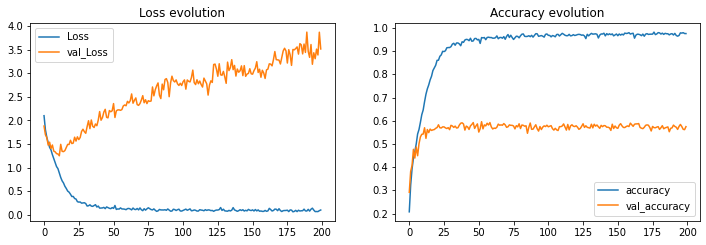

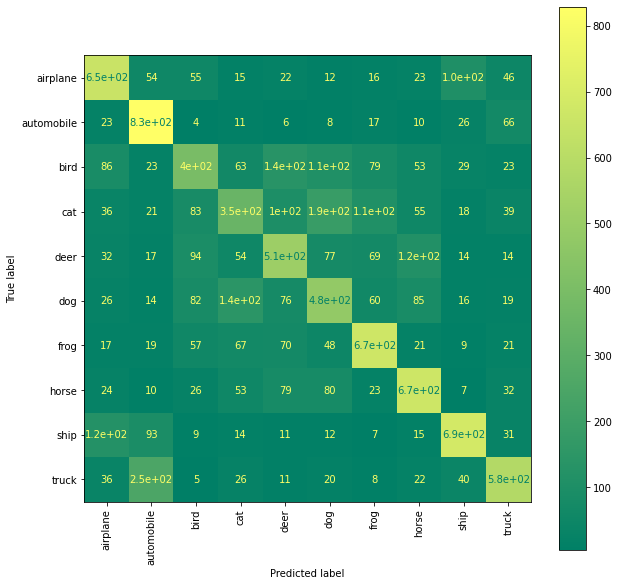

probabilities: (43000, 10) 
 [6 0 4 ... 6 1 0]
Uncertain_samples shape : (1000,)
trainset before (7000, 32, 32, 3) (7000, 1)
trainset after (8000, 32, 32, 3) (8000, 1)
updated train set: (8000, 32, 32, 3) (8000, 1) unique(labels): [765 831 780 805 877 817 744 803 782 796] [0 1 2 3 4 5 6 7 8 9]
Seed set: (42000, 32, 32, 3) (42000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (5600, 32, 32, 3)
y train : (5600, 1)
X val : (2400, 32, 32, 3)
y val: (2400, 1)
Epoch 1/200
175/175 [==============================] - 2s 11ms/step - loss: 2.0915 - accuracy: 0.2154 - val_loss: 1.8143 - val_accuracy: 0.3429
Epoch 2/200
175/175 [==============================] - 2s 11ms/step - loss: 1.7564 - accuracy: 0.3482 - val_loss: 1.6100 - val_accuracy: 0.3946
Epoch 3/200
175/175 [==============================] - 2s 10ms/step - loss: 1.6036 - accuracy: 0.4091 - val_loss: 1.5035 - val_accuracy: 0.4538
Epoch 4/200
175/175 [==============================] - 2s 10ms/step - loss: 1.4855 

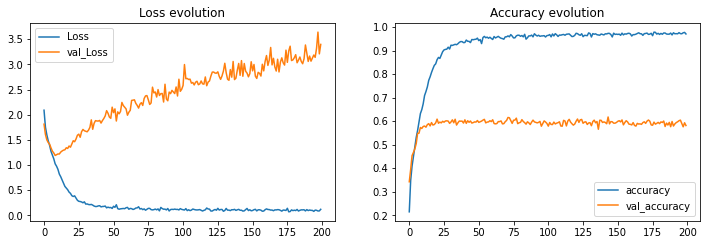

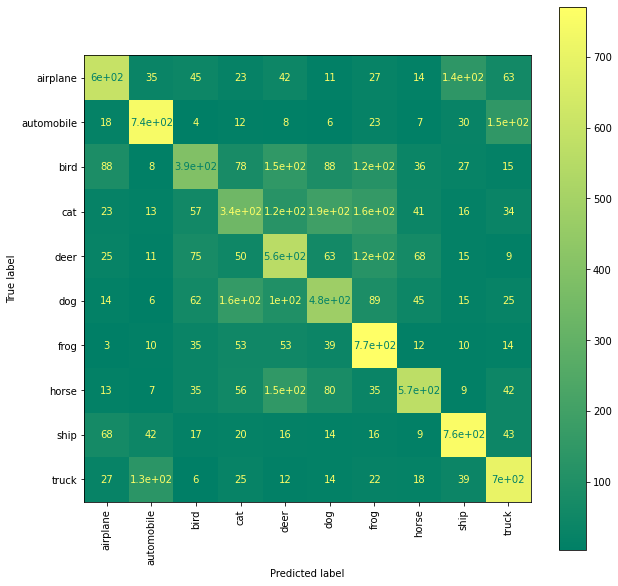

probabilities: (42000, 10) 
 [6 9 4 ... 6 1 9]
Uncertain_samples shape : (1000,)
trainset before (8000, 32, 32, 3) (8000, 1)
trainset after (9000, 32, 32, 3) (9000, 1)
updated train set: (9000, 32, 32, 3) (9000, 1) unique(labels): [869 938 878 903 982 932 837 902 874 885] [0 1 2 3 4 5 6 7 8 9]
Seed set: (41000, 32, 32, 3) (41000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (6300, 32, 32, 3)
y train : (6300, 1)
X val : (2700, 32, 32, 3)
y val: (2700, 1)
Epoch 1/200
197/197 [==============================] - 2s 11ms/step - loss: 2.0197 - accuracy: 0.2363 - val_loss: 1.8170 - val_accuracy: 0.3448
Epoch 2/200
197/197 [==============================] - 2s 12ms/step - loss: 1.6862 - accuracy: 0.3781 - val_loss: 1.5595 - val_accuracy: 0.4437
Epoch 3/200
197/197 [==============================] - 2s 11ms/step - loss: 1.5337 - accuracy: 0.4376 - val_loss: 1.4721 - val_accuracy: 0.4526
Epoch 4/200
197/197 [==============================] - 2s 11ms/step - loss: 1.4180 

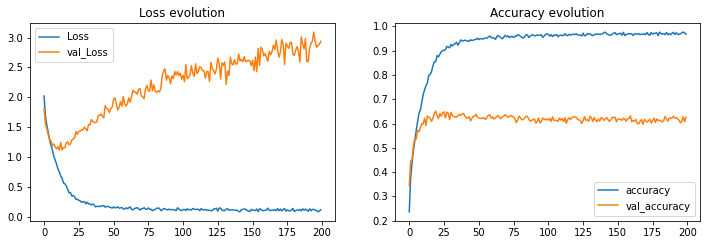

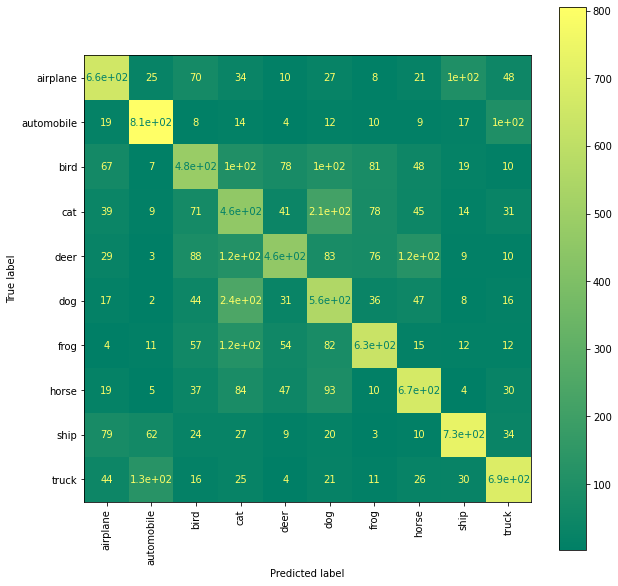

probabilities: (41000, 10) 
 [7 9 4 ... 6 1 1]
Uncertain_samples shape : (1000,)
trainset before (9000, 32, 32, 3) (9000, 1)
trainset after (10000, 32, 32, 3) (10000, 1)
updated train set: (10000, 32, 32, 3) (10000, 1) unique(labels): [ 979 1043  987  994 1071 1037  932 1004  962  991] [0 1 2 3 4 5 6 7 8 9]
Seed set: (40000, 32, 32, 3) (40000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (7000, 32, 32, 3)
y train : (7000, 1)
X val : (3000, 32, 32, 3)
y val: (3000, 1)
Epoch 1/200
219/219 [==============================] - 2s 11ms/step - loss: 2.0045 - accuracy: 0.2573 - val_loss: 1.7649 - val_accuracy: 0.3407
Epoch 2/200
219/219 [==============================] - 2s 11ms/step - loss: 1.6638 - accuracy: 0.3876 - val_loss: 1.5396 - val_accuracy: 0.4460
Epoch 3/200
219/219 [==============================] - 2s 11ms/step - loss: 1.5077 - accuracy: 0.4487 - val_loss: 1.4445 - val_accuracy: 0.4750
Epoch 4/200
219/219 [==============================] - 2s 11ms/step -

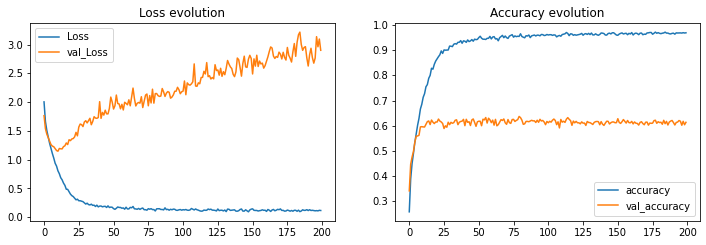

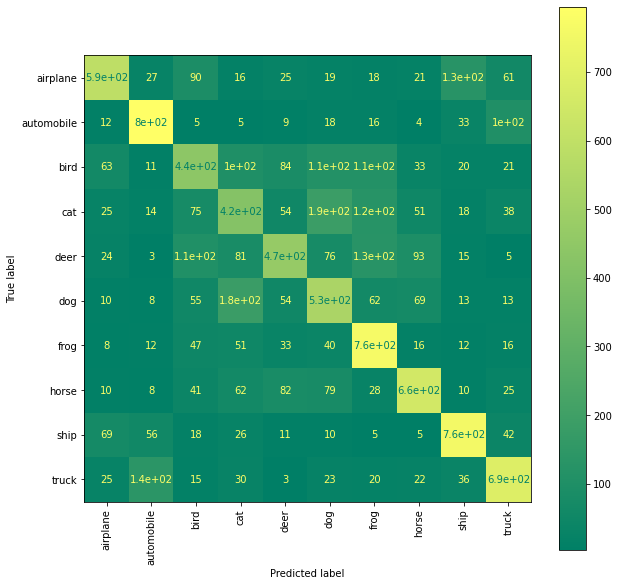

probabilities: (40000, 10) 
 [5 9 4 ... 6 1 0]
Uncertain_samples shape : (1000,)
trainset before (10000, 32, 32, 3) (10000, 1)
trainset after (11000, 32, 32, 3) (11000, 1)
updated train set: (11000, 32, 32, 3) (11000, 1) unique(labels): [1088 1136 1089 1085 1174 1142 1037 1114 1061 1074] [0 1 2 3 4 5 6 7 8 9]
Seed set: (39000, 32, 32, 3) (39000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (7700, 32, 32, 3)
y train : (7700, 1)
X val : (3300, 32, 32, 3)
y val: (3300, 1)
Epoch 1/200
241/241 [==============================] - 3s 11ms/step - loss: 2.0072 - accuracy: 0.2606 - val_loss: 1.7637 - val_accuracy: 0.3573
Epoch 2/200
241/241 [==============================] - 3s 11ms/step - loss: 1.6848 - accuracy: 0.3806 - val_loss: 1.6292 - val_accuracy: 0.4118
Epoch 3/200
241/241 [==============================] - 3s 11ms/step - loss: 1.5259 - accuracy: 0.4400 - val_loss: 1.5136 - val_accuracy: 0.4515
Epoch 4/200
241/241 [==============================] - 3s 11ms/step

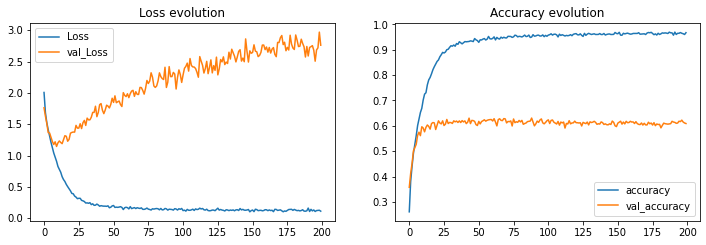

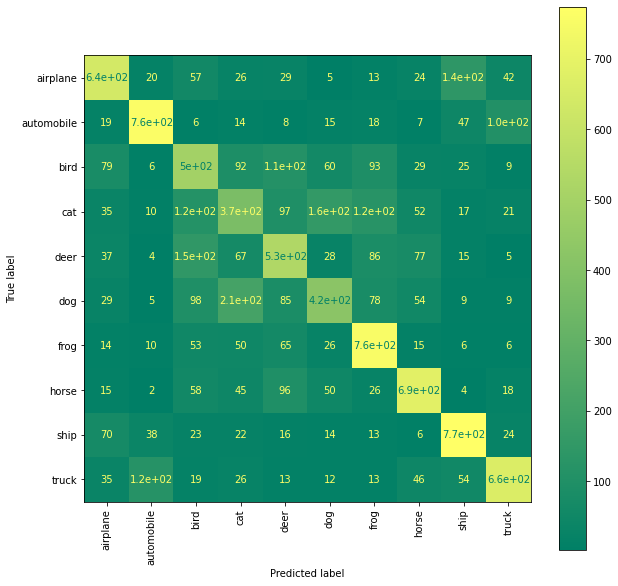

probabilities: (39000, 10) 
 [2 9 6 ... 2 1 3]
Uncertain_samples shape : (1000,)
trainset before (11000, 32, 32, 3) (11000, 1)
trainset after (12000, 32, 32, 3) (12000, 1)
updated train set: (12000, 32, 32, 3) (12000, 1) unique(labels): [1184 1222 1195 1182 1267 1238 1142 1220 1161 1189] [0 1 2 3 4 5 6 7 8 9]
Seed set: (38000, 32, 32, 3) (38000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (8400, 32, 32, 3)
y train : (8400, 1)
X val : (3600, 32, 32, 3)
y val: (3600, 1)
Epoch 1/200
263/263 [==============================] - 3s 11ms/step - loss: 1.9285 - accuracy: 0.2817 - val_loss: 1.7528 - val_accuracy: 0.3631
Epoch 2/200
263/263 [==============================] - 3s 11ms/step - loss: 1.5734 - accuracy: 0.4196 - val_loss: 1.4691 - val_accuracy: 0.4736
Epoch 3/200
263/263 [==============================] - 3s 11ms/step - loss: 1.4342 - accuracy: 0.4789 - val_loss: 1.4013 - val_accuracy: 0.4928
Epoch 4/200
263/263 [==============================] - 3s 11ms/step

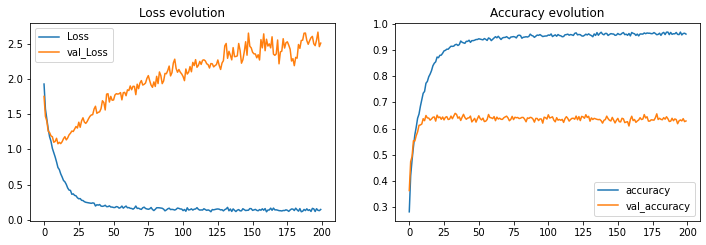

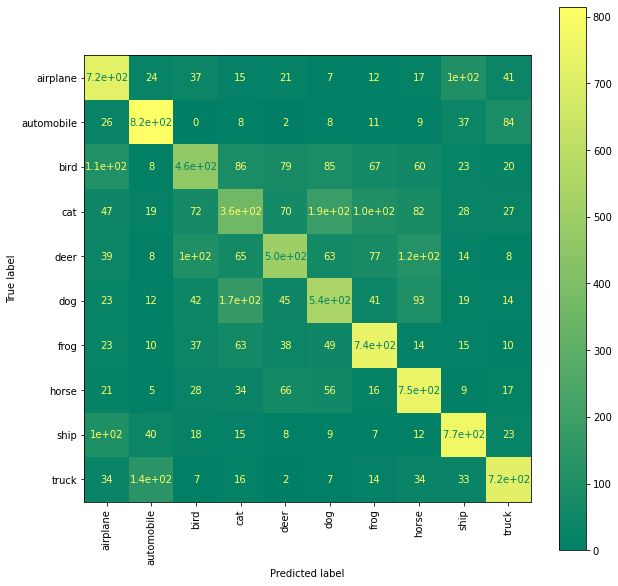

probabilities: (38000, 10) 
 [6 9 4 ... 6 1 9]
Uncertain_samples shape : (1000,)
trainset before (12000, 32, 32, 3) (12000, 1)
trainset after (13000, 32, 32, 3) (13000, 1)
updated train set: (13000, 32, 32, 3) (13000, 1) unique(labels): [1276 1339 1304 1281 1359 1347 1260 1308 1249 1277] [0 1 2 3 4 5 6 7 8 9]
Seed set: (37000, 32, 32, 3) (37000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (9100, 32, 32, 3)
y train : (9100, 1)
X val : (3900, 32, 32, 3)
y val: (3900, 1)
Epoch 1/200
285/285 [==============================] - 3s 11ms/step - loss: 2.0282 - accuracy: 0.2366 - val_loss: 1.6896 - val_accuracy: 0.3769
Epoch 2/200
285/285 [==============================] - 3s 11ms/step - loss: 1.6145 - accuracy: 0.4013 - val_loss: 1.5025 - val_accuracy: 0.4610
Epoch 3/200
285/285 [==============================] - 3s 11ms/step - loss: 1.4470 - accuracy: 0.4712 - val_loss: 1.4485 - val_accuracy: 0.4926
Epoch 4/200
285/285 [==============================] - 3s 11ms/step

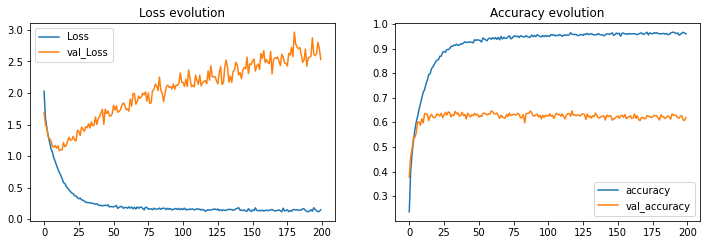

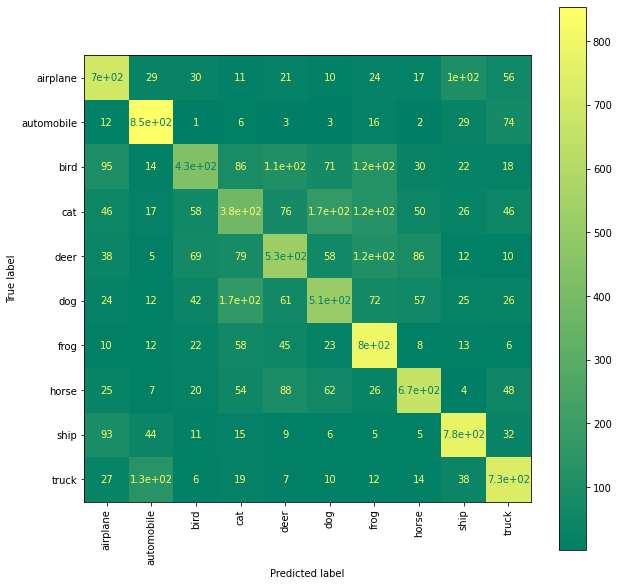

probabilities: (37000, 10) 
 [6 9 4 ... 6 1 9]
Uncertain_samples shape : (1000,)
trainset before (13000, 32, 32, 3) (13000, 1)
trainset after (14000, 32, 32, 3) (14000, 1)
updated train set: (14000, 32, 32, 3) (14000, 1) unique(labels): [1373 1434 1398 1374 1467 1453 1362 1419 1339 1381] [0 1 2 3 4 5 6 7 8 9]
Seed set: (36000, 32, 32, 3) (36000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (9800, 32, 32, 3)
y train : (9800, 1)
X val : (4200, 32, 32, 3)
y val: (4200, 1)
Epoch 1/200
307/307 [==============================] - 3s 11ms/step - loss: 1.9118 - accuracy: 0.2816 - val_loss: 1.6454 - val_accuracy: 0.3933
Epoch 2/200
307/307 [==============================] - 3s 11ms/step - loss: 1.5615 - accuracy: 0.4297 - val_loss: 1.5169 - val_accuracy: 0.4493
Epoch 3/200
307/307 [==============================] - 3s 11ms/step - loss: 1.4169 - accuracy: 0.4882 - val_loss: 1.3452 - val_accuracy: 0.5210
Epoch 4/200
307/307 [==============================] - 3s 11ms/step

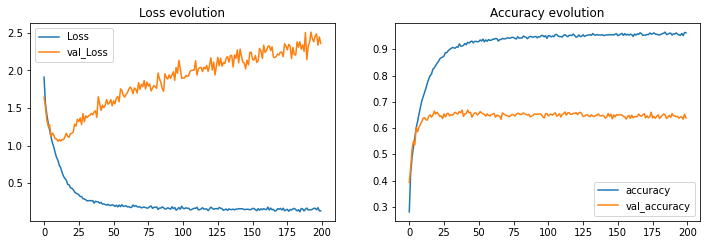

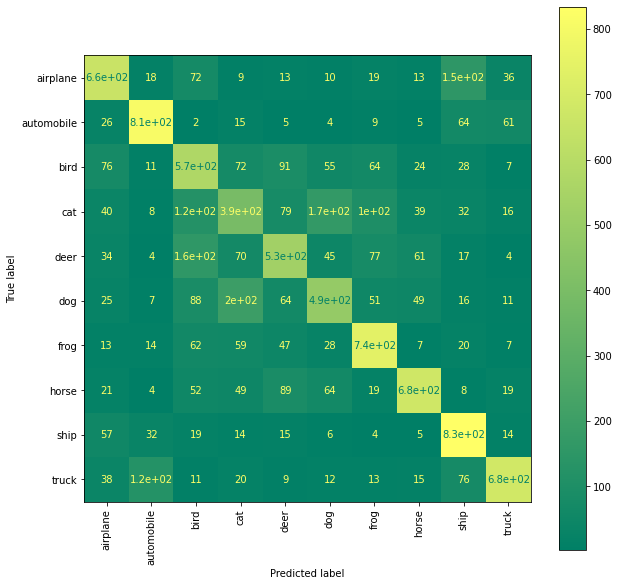

probabilities: (36000, 10) 
 [6 9 4 ... 8 1 8]
Uncertain_samples shape : (1000,)
trainset before (14000, 32, 32, 3) (14000, 1)
trainset after (15000, 32, 32, 3) (15000, 1)
updated train set: (15000, 32, 32, 3) (15000, 1) unique(labels): [1483 1536 1516 1474 1565 1537 1458 1520 1446 1465] [0 1 2 3 4 5 6 7 8 9]
Seed set: (35000, 32, 32, 3) (35000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (10500, 32, 32, 3)
y train : (10500, 1)
X val : (4500, 32, 32, 3)
y val: (4500, 1)
Epoch 1/200
329/329 [==============================] - 4s 11ms/step - loss: 1.9128 - accuracy: 0.2868 - val_loss: 1.7785 - val_accuracy: 0.3336
Epoch 2/200
329/329 [==============================] - 3s 11ms/step - loss: 1.5831 - accuracy: 0.4173 - val_loss: 1.4651 - val_accuracy: 0.4789
Epoch 3/200
329/329 [==============================] - 4s 11ms/step - loss: 1.4205 - accuracy: 0.4907 - val_loss: 1.3037 - val_accuracy: 0.5351
Epoch 4/200
329/329 [==============================] - 4s 11ms/st

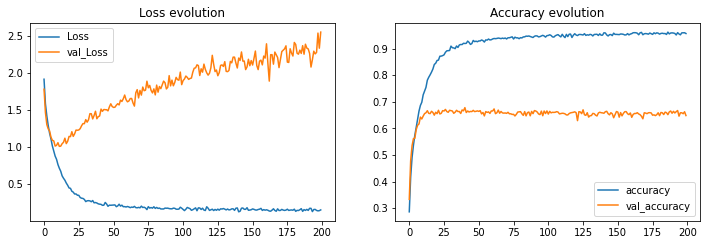

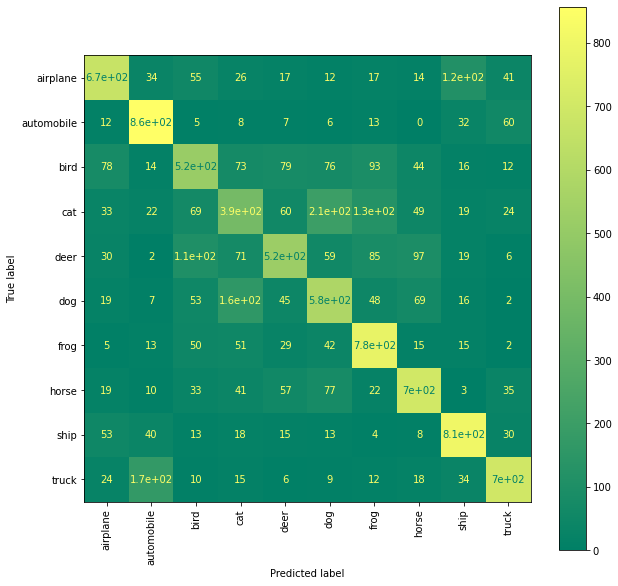

probabilities: (35000, 10) 
 [6 9 6 ... 0 1 8]
Uncertain_samples shape : (1000,)
trainset before (15000, 32, 32, 3) (15000, 1)
trainset after (16000, 32, 32, 3) (16000, 1)
updated train set: (16000, 32, 32, 3) (16000, 1) unique(labels): [1596 1629 1623 1588 1655 1634 1556 1608 1543 1568] [0 1 2 3 4 5 6 7 8 9]
Seed set: (34000, 32, 32, 3) (34000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (11200, 32, 32, 3)
y train : (11200, 1)
X val : (4800, 32, 32, 3)
y val: (4800, 1)
Epoch 1/200
350/350 [==============================] - 4s 11ms/step - loss: 1.8832 - accuracy: 0.2939 - val_loss: 1.6068 - val_accuracy: 0.4112
Epoch 2/200
350/350 [==============================] - 4s 10ms/step - loss: 1.5474 - accuracy: 0.4313 - val_loss: 1.5191 - val_accuracy: 0.4442
Epoch 3/200
350/350 [==============================] - 4s 10ms/step - loss: 1.4058 - accuracy: 0.4899 - val_loss: 1.3233 - val_accuracy: 0.5190
Epoch 4/200
350/350 [==============================] - 4s 10ms/st

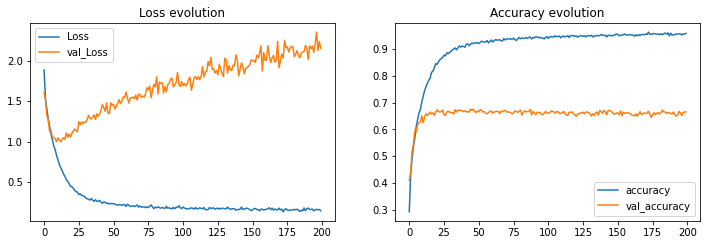

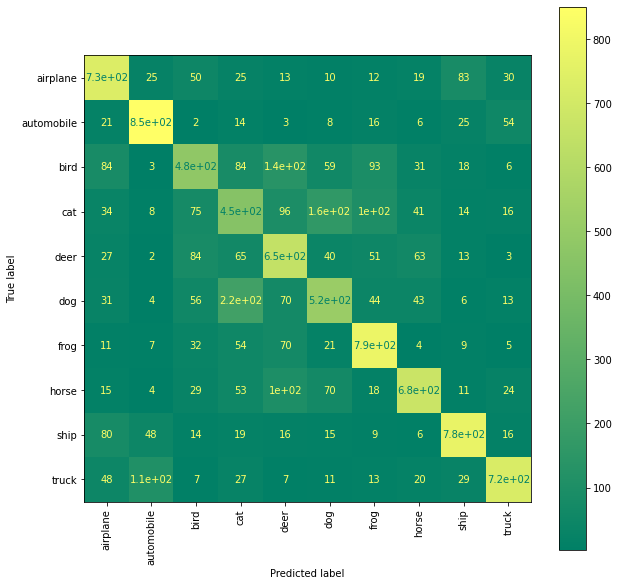

probabilities: (34000, 10) 
 [6 9 4 ... 3 1 9]
Uncertain_samples shape : (1000,)
trainset before (16000, 32, 32, 3) (16000, 1)
trainset after (17000, 32, 32, 3) (17000, 1)
updated train set: (17000, 32, 32, 3) (17000, 1) unique(labels): [1689 1724 1728 1674 1761 1735 1656 1726 1642 1665] [0 1 2 3 4 5 6 7 8 9]
Seed set: (33000, 32, 32, 3) (33000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (11900, 32, 32, 3)
y train : (11900, 1)
X val : (5100, 32, 32, 3)
y val: (5100, 1)
Epoch 1/200
372/372 [==============================] - 4s 11ms/step - loss: 1.8852 - accuracy: 0.2988 - val_loss: 1.6001 - val_accuracy: 0.4082
Epoch 2/200
372/372 [==============================] - 4s 11ms/step - loss: 1.5478 - accuracy: 0.4320 - val_loss: 1.4834 - val_accuracy: 0.4598
Epoch 3/200
372/372 [==============================] - 4s 11ms/step - loss: 1.4019 - accuracy: 0.4899 - val_loss: 1.3459 - val_accuracy: 0.5020
Epoch 4/200
372/372 [==============================] - 4s 11ms/st

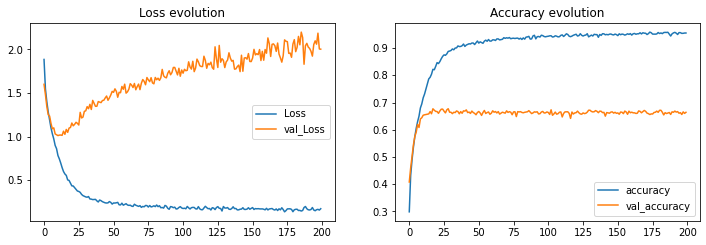

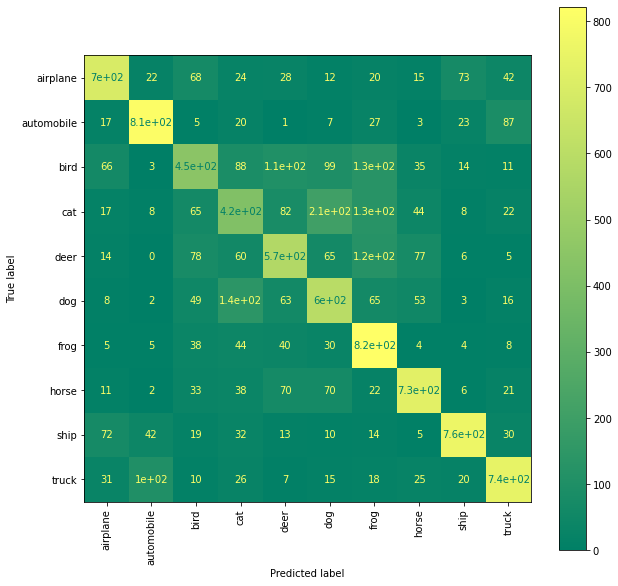

probabilities: (33000, 10) 
 [6 9 6 ... 8 1 0]
Uncertain_samples shape : (1000,)
trainset before (17000, 32, 32, 3) (17000, 1)
trainset after (18000, 32, 32, 3) (18000, 1)
updated train set: (18000, 32, 32, 3) (18000, 1) unique(labels): [1788 1832 1827 1786 1856 1825 1744 1825 1754 1763] [0 1 2 3 4 5 6 7 8 9]
Seed set: (32000, 32, 32, 3) (32000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (12600, 32, 32, 3)
y train : (12600, 1)
X val : (5400, 32, 32, 3)
y val: (5400, 1)
Epoch 1/200
394/394 [==============================] - 4s 11ms/step - loss: 1.8930 - accuracy: 0.2998 - val_loss: 1.5837 - val_accuracy: 0.4183
Epoch 2/200
394/394 [==============================] - 4s 11ms/step - loss: 1.5103 - accuracy: 0.4413 - val_loss: 1.3685 - val_accuracy: 0.5083
Epoch 3/200
394/394 [==============================] - 4s 11ms/step - loss: 1.3494 - accuracy: 0.5133 - val_loss: 1.2547 - val_accuracy: 0.5513
Epoch 4/200
394/394 [==============================] - 4s 11ms/st

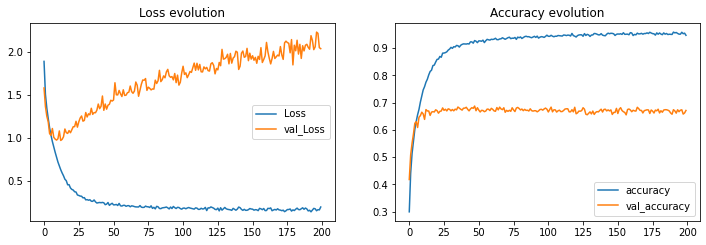

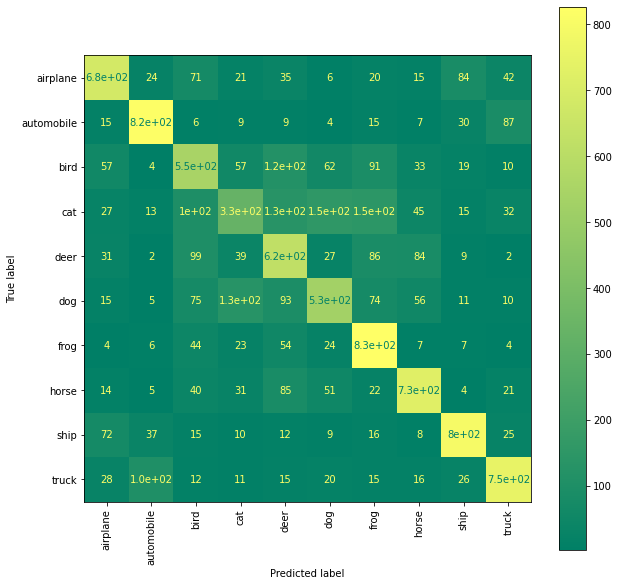

probabilities: (32000, 10) 
 [6 9 4 ... 0 1 8]
Uncertain_samples shape : (1000,)
trainset before (18000, 32, 32, 3) (18000, 1)
trainset after (19000, 32, 32, 3) (19000, 1)
updated train set: (19000, 32, 32, 3) (19000, 1) unique(labels): [1891 1923 1905 1877 1948 1932 1856 1928 1859 1881] [0 1 2 3 4 5 6 7 8 9]
Seed set: (31000, 32, 32, 3) (31000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (13300, 32, 32, 3)
y train : (13300, 1)
X val : (5700, 32, 32, 3)
y val: (5700, 1)
Epoch 1/200
416/416 [==============================] - 5s 11ms/step - loss: 1.8829 - accuracy: 0.2978 - val_loss: 1.5342 - val_accuracy: 0.4363
Epoch 2/200
416/416 [==============================] - 4s 11ms/step - loss: 1.4934 - accuracy: 0.4486 - val_loss: 1.4029 - val_accuracy: 0.4967
Epoch 3/200
416/416 [==============================] - 4s 11ms/step - loss: 1.3361 - accuracy: 0.5169 - val_loss: 1.3077 - val_accuracy: 0.5279
Epoch 4/200
416/416 [==============================] - 4s 11ms/st

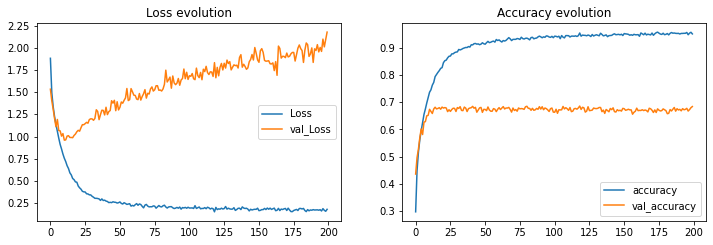

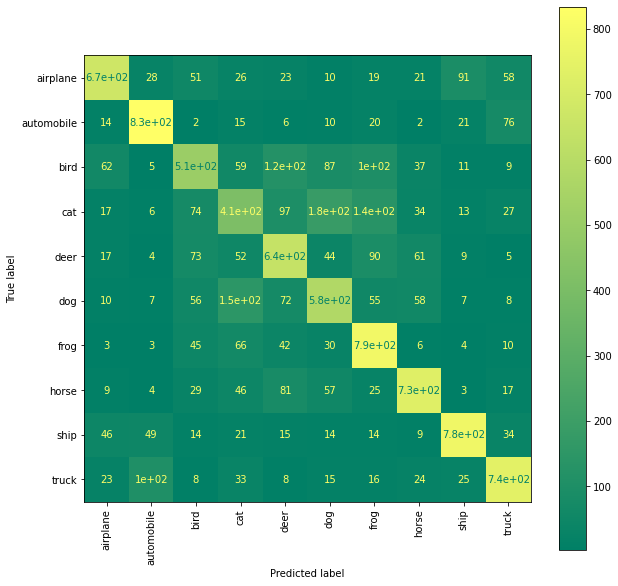

probabilities: (31000, 10) 
 [6 9 4 ... 8 1 8]
Uncertain_samples shape : (1000,)
trainset before (19000, 32, 32, 3) (19000, 1)
trainset after (20000, 32, 32, 3) (20000, 1)
updated train set: (20000, 32, 32, 3) (20000, 1) unique(labels): [1988 2005 2014 1979 2057 2045 1955 2016 1952 1989] [0 1 2 3 4 5 6 7 8 9]
Seed set: (30000, 32, 32, 3) (30000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (14000, 32, 32, 3)
y train : (14000, 1)
X val : (6000, 32, 32, 3)
y val: (6000, 1)
Epoch 1/200
438/438 [==============================] - 5s 11ms/step - loss: 1.8566 - accuracy: 0.3083 - val_loss: 1.5311 - val_accuracy: 0.4437
Epoch 2/200
438/438 [==============================] - 5s 12ms/step - loss: 1.5024 - accuracy: 0.4522 - val_loss: 1.4145 - val_accuracy: 0.4955
Epoch 3/200
438/438 [==============================] - 5s 11ms/step - loss: 1.3318 - accuracy: 0.5258 - val_loss: 1.2333 - val_accuracy: 0.5638
Epoch 4/200
438/438 [==============================] - 5s 11ms/st

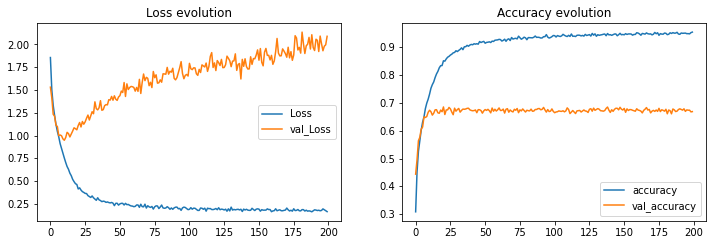

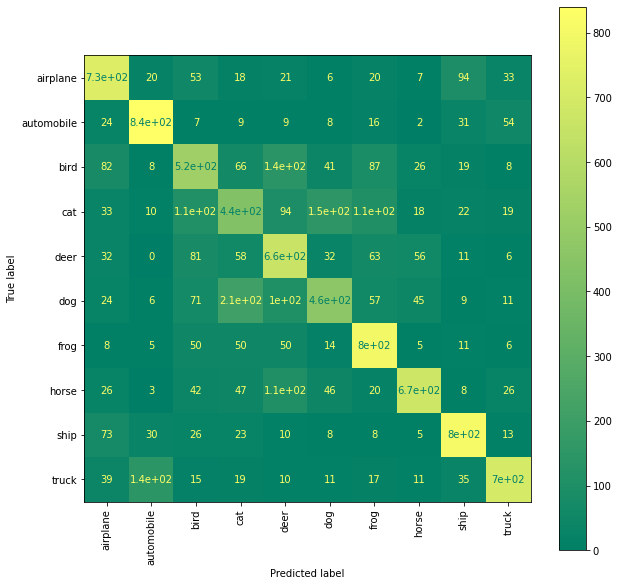

probabilities: (30000, 10) 
 [6 9 4 ... 0 1 3]
Uncertain_samples shape : (1000,)
trainset before (20000, 32, 32, 3) (20000, 1)
trainset after (21000, 32, 32, 3) (21000, 1)
updated train set: (21000, 32, 32, 3) (21000, 1) unique(labels): [2100 2104 2101 2090 2154 2151 2058 2126 2039 2077] [0 1 2 3 4 5 6 7 8 9]
Seed set: (29000, 32, 32, 3) (29000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (14700, 32, 32, 3)
y train : (14700, 1)
X val : (6300, 32, 32, 3)
y val: (6300, 1)
Epoch 1/200
460/460 [==============================] - 5s 11ms/step - loss: 1.7987 - accuracy: 0.3329 - val_loss: 1.5649 - val_accuracy: 0.4317
Epoch 2/200
460/460 [==============================] - 5s 11ms/step - loss: 1.4330 - accuracy: 0.4771 - val_loss: 1.3792 - val_accuracy: 0.5048
Epoch 3/200
460/460 [==============================] - 5s 11ms/step - loss: 1.2853 - accuracy: 0.5363 - val_loss: 1.1800 - val_accuracy: 0.5663
Epoch 4/200
460/460 [==============================] - 5s 11ms/st

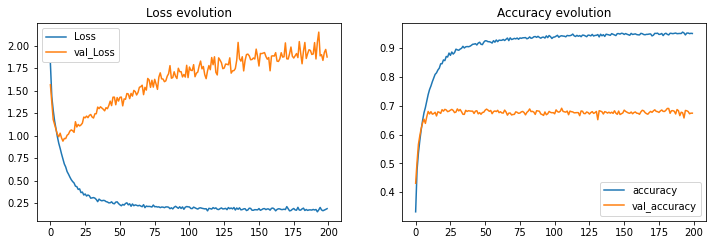

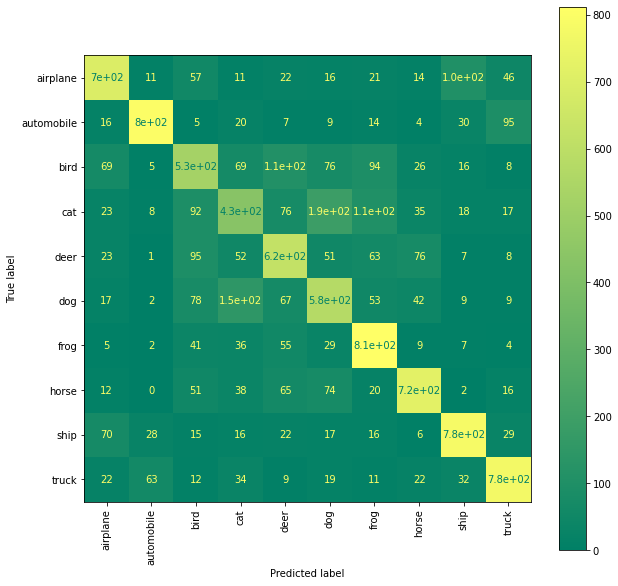

probabilities: (29000, 10) 
 [6 9 4 ... 8 1 0]
Uncertain_samples shape : (1000,)
trainset before (21000, 32, 32, 3) (21000, 1)
trainset after (22000, 32, 32, 3) (22000, 1)
updated train set: (22000, 32, 32, 3) (22000, 1) unique(labels): [2213 2193 2199 2168 2250 2254 2167 2226 2138 2192] [0 1 2 3 4 5 6 7 8 9]
Seed set: (28000, 32, 32, 3) (28000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (15400, 32, 32, 3)
y train : (15400, 1)
X val : (6600, 32, 32, 3)
y val: (6600, 1)
Epoch 1/200
482/482 [==============================] - 5s 11ms/step - loss: 1.8216 - accuracy: 0.3241 - val_loss: 1.5607 - val_accuracy: 0.4147
Epoch 2/200
482/482 [==============================] - 5s 11ms/step - loss: 1.4743 - accuracy: 0.4618 - val_loss: 1.3630 - val_accuracy: 0.5011
Epoch 3/200
482/482 [==============================] - 5s 11ms/step - loss: 1.3068 - accuracy: 0.5306 - val_loss: 1.2143 - val_accuracy: 0.5677
Epoch 4/200
482/482 [==============================] - 5s 11ms/st

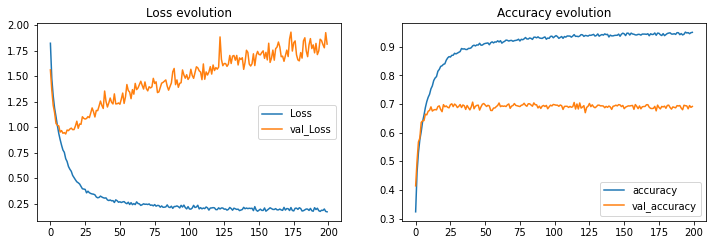

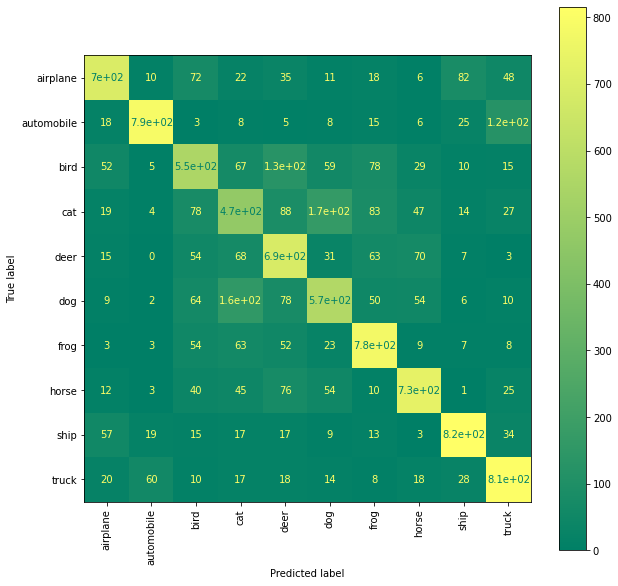

probabilities: (28000, 10) 
 [6 9 4 ... 8 1 0]
Uncertain_samples shape : (1000,)
trainset before (22000, 32, 32, 3) (22000, 1)
trainset after (23000, 32, 32, 3) (23000, 1)
updated train set: (23000, 32, 32, 3) (23000, 1) unique(labels): [2311 2306 2281 2267 2337 2355 2258 2344 2245 2296] [0 1 2 3 4 5 6 7 8 9]
Seed set: (27000, 32, 32, 3) (27000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (16100, 32, 32, 3)
y train : (16100, 1)
X val : (6900, 32, 32, 3)
y val: (6900, 1)
Epoch 1/200
504/504 [==============================] - 5s 11ms/step - loss: 1.8124 - accuracy: 0.3280 - val_loss: 1.5044 - val_accuracy: 0.4441
Epoch 2/200
504/504 [==============================] - 5s 11ms/step - loss: 1.4544 - accuracy: 0.4706 - val_loss: 1.3554 - val_accuracy: 0.5100
Epoch 3/200
504/504 [==============================] - 5s 11ms/step - loss: 1.2972 - accuracy: 0.5350 - val_loss: 1.2474 - val_accuracy: 0.5580
Epoch 4/200
504/504 [==============================] - 5s 11ms/st

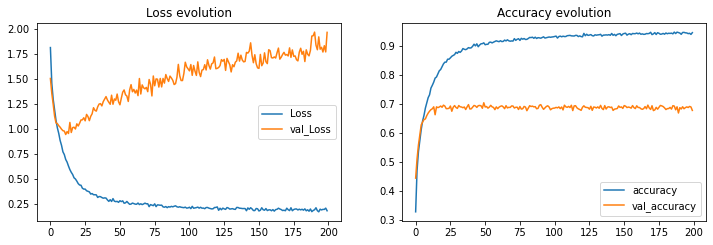

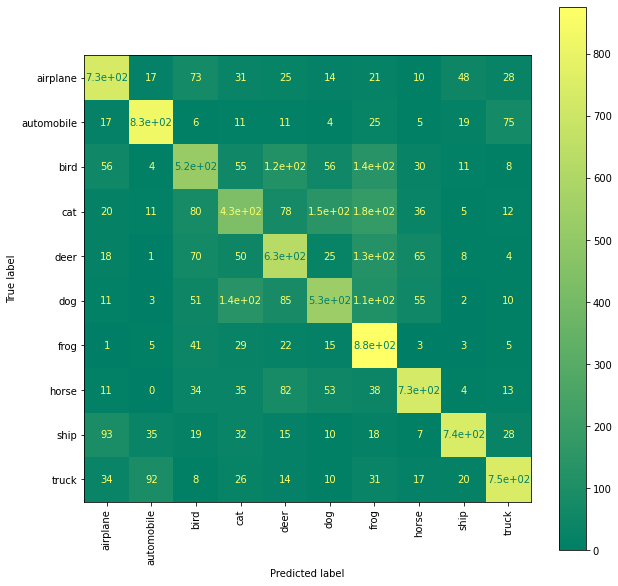

probabilities: (27000, 10) 
 [6 9 4 ... 1 0 1]
Uncertain_samples shape : (1000,)
trainset before (23000, 32, 32, 3) (23000, 1)
trainset after (24000, 32, 32, 3) (24000, 1)
updated train set: (24000, 32, 32, 3) (24000, 1) unique(labels): [2406 2390 2406 2355 2425 2460 2370 2429 2364 2395] [0 1 2 3 4 5 6 7 8 9]
Seed set: (26000, 32, 32, 3) (26000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (16800, 32, 32, 3)
y train : (16800, 1)
X val : (7200, 32, 32, 3)
y val: (7200, 1)
Epoch 1/200
525/525 [==============================] - 6s 11ms/step - loss: 1.8076 - accuracy: 0.3286 - val_loss: 1.5221 - val_accuracy: 0.4510
Epoch 2/200
525/525 [==============================] - 5s 10ms/step - loss: 1.4467 - accuracy: 0.4739 - val_loss: 1.2745 - val_accuracy: 0.5503
Epoch 3/200
525/525 [==============================] - 6s 11ms/step - loss: 1.2776 - accuracy: 0.5387 - val_loss: 1.1573 - val_accuracy: 0.5872
Epoch 4/200
525/525 [==============================] - 6s 11ms/st

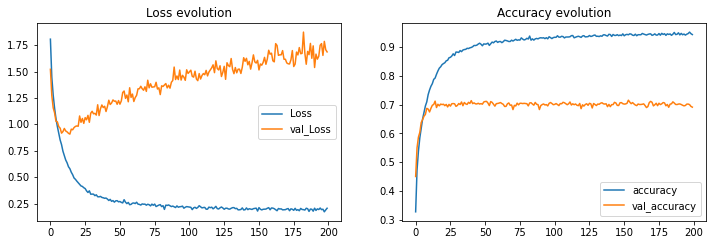

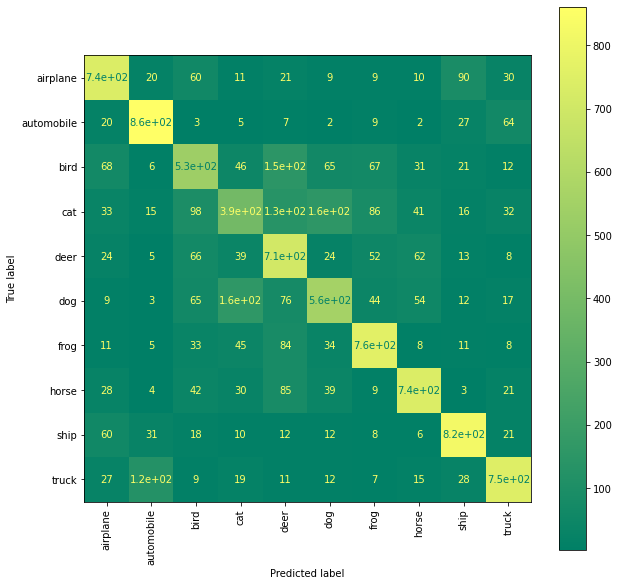

probabilities: (26000, 10) 
 [6 9 4 ... 1 8 1]
Uncertain_samples shape : (1000,)
trainset before (24000, 32, 32, 3) (24000, 1)
trainset after (25000, 32, 32, 3) (25000, 1)
updated train set: (25000, 32, 32, 3) (25000, 1) unique(labels): [2498 2484 2509 2471 2546 2554 2470 2524 2463 2481] [0 1 2 3 4 5 6 7 8 9]
Seed set: (25000, 32, 32, 3) (25000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (17500, 32, 32, 3)
y train : (17500, 1)
X val : (7500, 32, 32, 3)
y val: (7500, 1)
Epoch 1/200
547/547 [==============================] - 6s 11ms/step - loss: 1.7683 - accuracy: 0.3464 - val_loss: 1.4455 - val_accuracy: 0.4697
Epoch 2/200
547/547 [==============================] - 6s 11ms/step - loss: 1.4475 - accuracy: 0.4728 - val_loss: 1.4588 - val_accuracy: 0.4843
Epoch 3/200
547/547 [==============================] - 6s 11ms/step - loss: 1.2889 - accuracy: 0.5358 - val_loss: 1.1597 - val_accuracy: 0.5845
Epoch 4/200
547/547 [==============================] - 6s 11ms/st

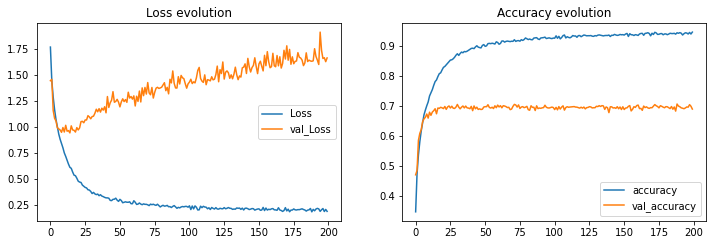

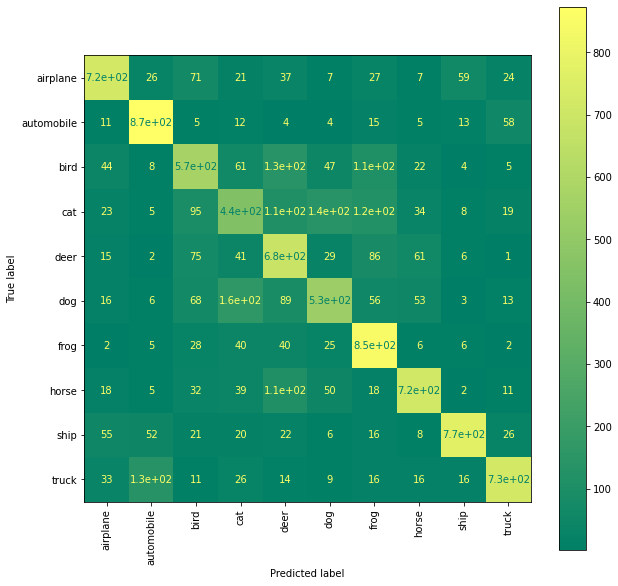

probabilities: (25000, 10) 
 [6 9 4 ... 1 4 1]
Uncertain_samples shape : (1000,)
trainset before (25000, 32, 32, 3) (25000, 1)
trainset after (26000, 32, 32, 3) (26000, 1)
updated train set: (26000, 32, 32, 3) (26000, 1) unique(labels): [2593 2586 2612 2570 2635 2644 2592 2616 2572 2580] [0 1 2 3 4 5 6 7 8 9]
Seed set: (24000, 32, 32, 3) (24000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (18200, 32, 32, 3)
y train : (18200, 1)
X val : (7800, 32, 32, 3)
y val: (7800, 1)
Epoch 1/200
569/569 [==============================] - 6s 11ms/step - loss: 1.7801 - accuracy: 0.3456 - val_loss: 1.5365 - val_accuracy: 0.4274
Epoch 2/200
569/569 [==============================] - 6s 11ms/step - loss: 1.4564 - accuracy: 0.4724 - val_loss: 1.2874 - val_accuracy: 0.5303
Epoch 3/200
569/569 [==============================] - 6s 11ms/step - loss: 1.2938 - accuracy: 0.5324 - val_loss: 1.1808 - val_accuracy: 0.5688
Epoch 4/200
569/569 [==============================] - 6s 11ms/st

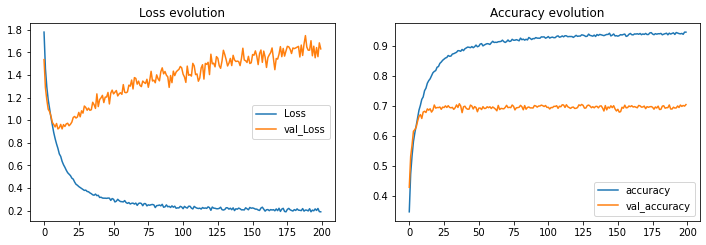

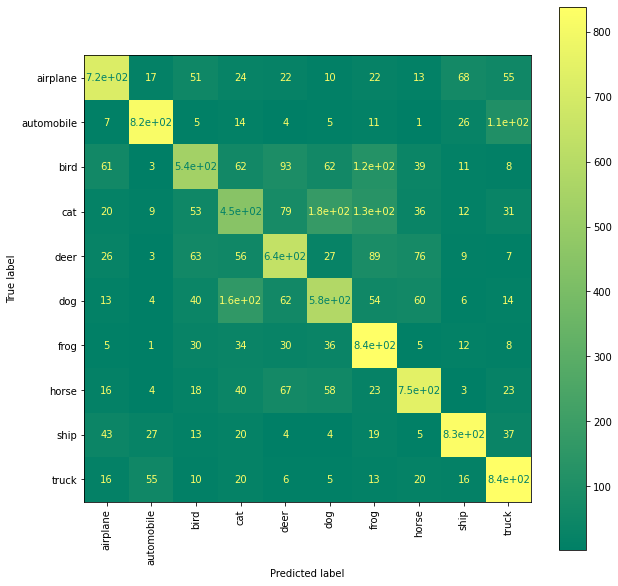

probabilities: (24000, 10) 
 [6 9 4 ... 1 4 1]
Uncertain_samples shape : (1000,)
trainset before (26000, 32, 32, 3) (26000, 1)
trainset after (27000, 32, 32, 3) (27000, 1)
updated train set: (27000, 32, 32, 3) (27000, 1) unique(labels): [2682 2680 2721 2672 2728 2735 2701 2713 2681 2687] [0 1 2 3 4 5 6 7 8 9]
Seed set: (23000, 32, 32, 3) (23000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (18900, 32, 32, 3)
y train : (18900, 1)
X val : (8100, 32, 32, 3)
y val: (8100, 1)
Epoch 1/200
591/591 [==============================] - 6s 11ms/step - loss: 1.7681 - accuracy: 0.3476 - val_loss: 1.4768 - val_accuracy: 0.4543
Epoch 2/200
591/591 [==============================] - 6s 11ms/step - loss: 1.4131 - accuracy: 0.4882 - val_loss: 1.2657 - val_accuracy: 0.5519
Epoch 3/200
591/591 [==============================] - 6s 11ms/step - loss: 1.2354 - accuracy: 0.5561 - val_loss: 1.1657 - val_accuracy: 0.5935
Epoch 4/200
591/591 [==============================] - 6s 11ms/st

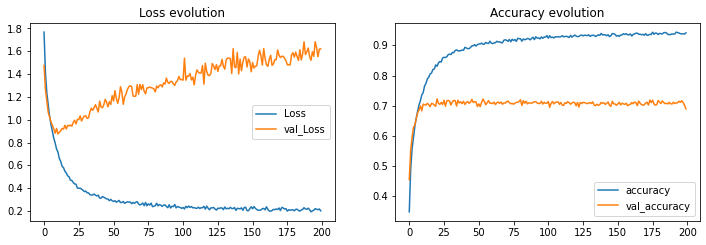

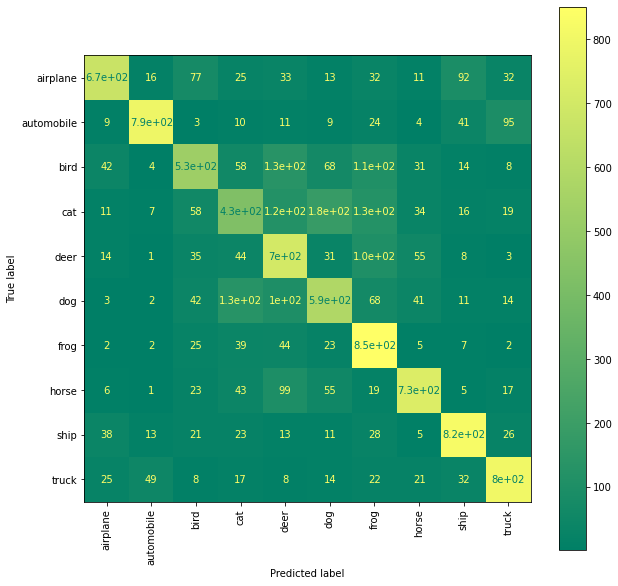

probabilities: (23000, 10) 
 [6 9 4 ... 1 8 1]
Uncertain_samples shape : (1000,)
trainset before (27000, 32, 32, 3) (27000, 1)
trainset after (28000, 32, 32, 3) (28000, 1)
updated train set: (28000, 32, 32, 3) (28000, 1) unique(labels): [2785 2783 2805 2777 2813 2828 2808 2823 2777 2801] [0 1 2 3 4 5 6 7 8 9]
Seed set: (22000, 32, 32, 3) (22000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (19600, 32, 32, 3)
y train : (19600, 1)
X val : (8400, 32, 32, 3)
y val: (8400, 1)
Epoch 1/200
613/613 [==============================] - 7s 11ms/step - loss: 1.7904 - accuracy: 0.3348 - val_loss: 1.4639 - val_accuracy: 0.4713
Epoch 2/200
613/613 [==============================] - 6s 11ms/step - loss: 1.3919 - accuracy: 0.4937 - val_loss: 1.2362 - val_accuracy: 0.5689
Epoch 3/200
613/613 [==============================] - 6s 11ms/step - loss: 1.2207 - accuracy: 0.5604 - val_loss: 1.1250 - val_accuracy: 0.6046
Epoch 4/200
613/613 [==============================] - 6s 10ms/st

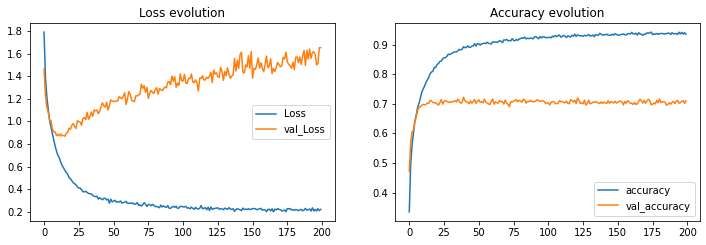

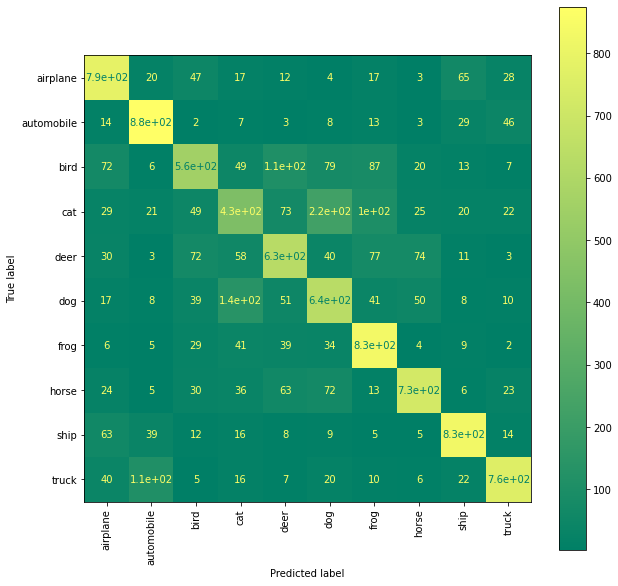

probabilities: (22000, 10) 
 [6 9 1 ... 1 8 1]
Uncertain_samples shape : (1000,)
trainset before (28000, 32, 32, 3) (28000, 1)
trainset after (29000, 32, 32, 3) (29000, 1)
updated train set: (29000, 32, 32, 3) (29000, 1) unique(labels): [2896 2886 2908 2873 2912 2925 2903 2919 2866 2912] [0 1 2 3 4 5 6 7 8 9]
Seed set: (21000, 32, 32, 3) (21000, 1)
-------Finish training anthor 1000 samples----------------
X_train : (20300, 32, 32, 3)
y train : (20300, 1)
X val : (8700, 32, 32, 3)
y val: (8700, 1)
Epoch 1/200
635/635 [==============================] - 7s 11ms/step - loss: 1.7549 - accuracy: 0.3500 - val_loss: 1.4661 - val_accuracy: 0.4659
Epoch 2/200
635/635 [==============================] - 7s 10ms/step - loss: 1.4061 - accuracy: 0.4878 - val_loss: 1.2556 - val_accuracy: 0.5536
Epoch 3/200
635/635 [==============================] - 7s 10ms/step - loss: 1.2434 - accuracy: 0.5547 - val_loss: 1.2546 - val_accuracy: 0.5472
Epoch 4/200
635/635 [==============================] - 7s 10ms/st

In [0]:
iterations = 1
while len(X_seedset) > 1 :
  #normalize
  normalizer = Normalize()
  X_train, y_train = normalizer.normalize( X_train, y_train)
  X_test, y_test = normalizer.normalize(X_test, y_test)
  X_seedset, y_seedset = normalizer.normalize(X_seedset, y_seedset)

  #train
  probas_val = train_resnet50(X_train, y_train, X_seedset,X_test, y_test)

  #get uncertain examples
  uncertain_samples = RandomSelection.select(probas_val, 1000)
  print('Uncertain_samples shape :', uncertain_samples.shape)
  #print('Uncertain_samples :', uncertain_samples)

  # normalization needs to be inversed and recalculated based on the new train and test set.
  X_train, y_train = normalizer.inverse(X_train, y_train)
  X_test, y_test = normalizer.inverse(X_test, y_test)
  X_seedset, y_seedset = normalizer.inverse(X_seedset, y_seedset)

  # get the uncertain samples from the validation set
  print ('trainset before', X_train.shape, y_train.shape)
  X_train = np.concatenate((X_train, X_seedset[uncertain_samples]))
  y_train = np.concatenate((y_train, y_seedset[uncertain_samples]))
  print ('trainset after', X_train.shape, y_train.shape)

  y_train_bin = y_train.reshape((y_train.shape[0],))
  bin_count = np.bincount(y_train_bin.astype('int64'))
  unique = np.unique(y_train_bin.astype('int64'))
  print ( 'updated train set:', X_train.shape,  y_train.shape, 'unique(labels):', bin_count, unique )

  X_seedset = np.delete(X_seedset, uncertain_samples, axis=0)
  y_seedset = np.delete(y_seedset, uncertain_samples, axis=0)
  print ('Seed set:', X_seedset.shape, y_seedset.shape)
  
  iterations += 1
  print('-------Finish training anthor 1000 samples----------------')

In [0]:
record